In [1]:
pip install collections


[notice] A new release of pip available: 22.1.2 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [2]:
pip install codecs


[notice] A new release of pip available: 22.1.2 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement codecs (from versions: none)
ERROR: No matching distribution found for codecs


In [3]:
pip install __future__


[notice] A new release of pip available: 22.1.2 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '__future__'


For this assignment I will be using naives bayes to classify if the text is a either positive or negative review.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from collections import Counter

In [6]:
from codecs import open
from __future__ import division

In [7]:
def read_documents(doc_file):
    docs= []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
    return docs, labels

In [8]:
all_docs, all_labels = read_documents('all_sentiment_shuffled.txt')


In [9]:
label_counts = Counter(all_labels)

In [10]:
labels__, counts = zip(*label_counts.items())

Count for each label: 
 neg    5914
pos    6000
dtype: int64


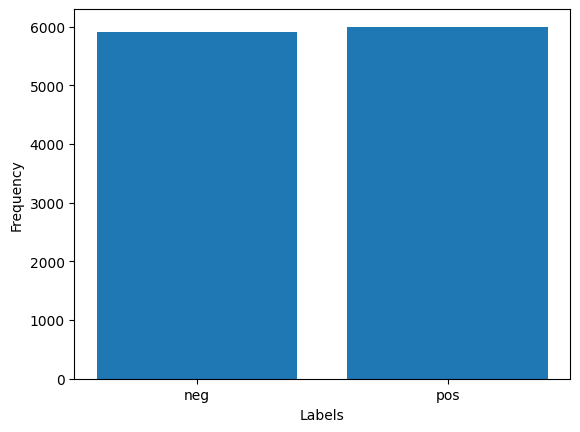

In [11]:
import pandas as pd
print("Count for each label:",'\n',pd.Series(label_counts))
plt.bar(labels__, counts)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()

There are 5914 negative reviews and 6000 positive reviews, indicating that there is a little undersampling, however, since these values are so close, it should not have an influence on the predictive accuracy of the naives bayes model.

In [12]:
split_point = int(0.80*len(all_docs))
train_docs = all_docs[:split_point]
train_labels = all_labels[:split_point]
eval_docs = all_docs[split_point:]
eval_labels = all_labels[split_point:]

In [13]:
freq_all = Counter(word for doc in all_docs for word in doc)

In [14]:
most_common = freq_all.most_common(30)

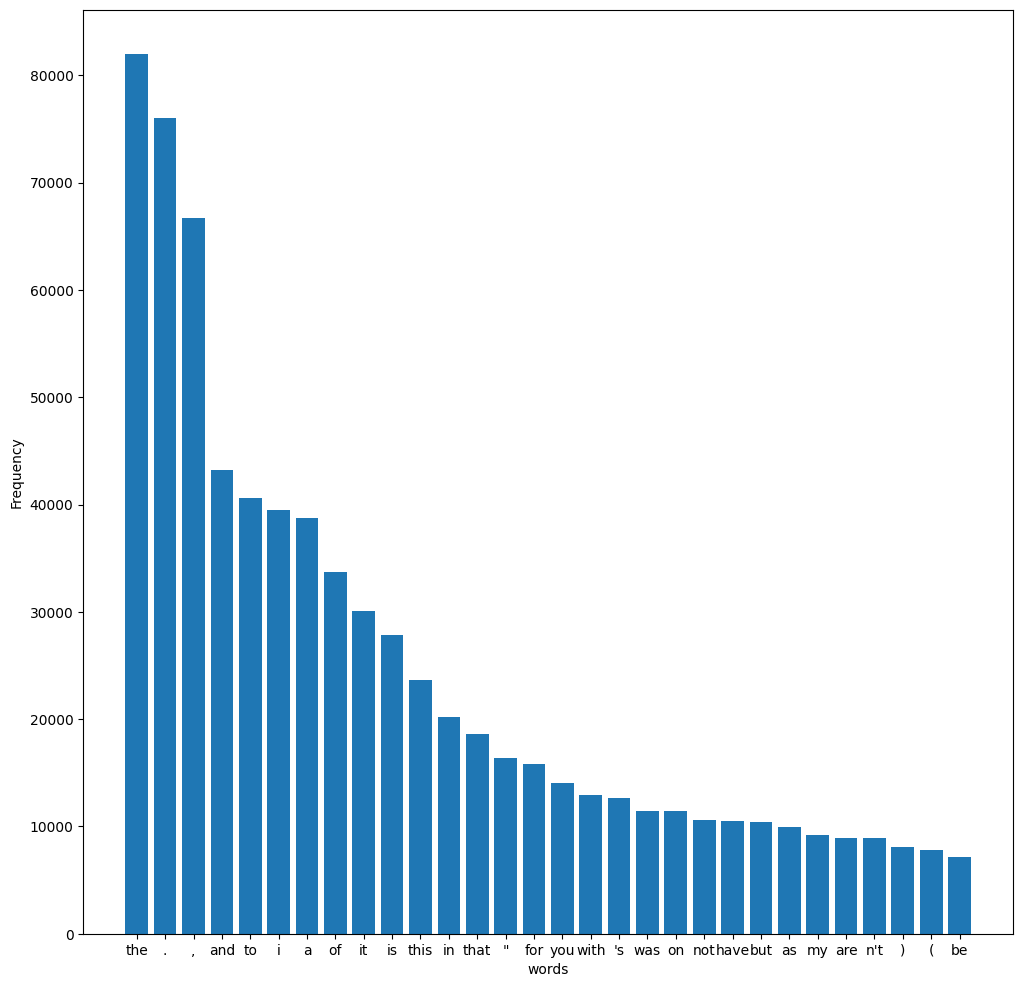

In [15]:

words, frequencies = zip(*most_common)
plt.figure(figsize = (12,12))
plt.bar(words, frequencies)
plt.xlabel("words")
plt.ylabel("Frequency")
plt.show()

According the bar graph, the top 30 most common words are all stopwords or punctuations. Since, these words are not going to be removed, this will decrease the predictive accuracy of the model.

In [16]:
def train_nb(documents, labels):

    class_count = Counter(labels)


    word_count = {}


    total_words = Counter()


    freqs2 = Counter()
    for doc in documents:
        freqs2.update(doc)


    for doc, label in zip(documents, labels):

        word_count[label] = word_count.get(label, Counter()) + Counter(doc)


        total_words += Counter(doc)


    prior_probs = {label: count / len(labels) for label, count in class_count.items()}


    words_size = len(total_words)
    word_probs = {}
    smoothing_factor = 1.0

    for label in class_count:
        label_word_count = word_count.get(label, Counter())
        word_probs[label] = {word: (count + smoothing_factor) / (sum(label_word_count.values()) + smoothing_factor * words_size) for word, count in freqs2.items()}

    return prior_probs, word_probs



In [17]:
prior_probs, word_probs = train_nb(train_docs, train_labels)

In [18]:
import numpy
from collections import Counter

def score_doc_label(document, label, prior_probs, word_probs):
    log_prob = np.log(prior_probs[label])

    for word in document:
        if word in word_probs[label]:
            log_prob += np.log(word_probs[label][word])
        else:

            log_prob += np.log(1.0 / (sum(word_probs[label].values()) + len(word_probs[label])))

    return log_prob


In [19]:

def classify_nb(document, prior_probs, word_probs):
    log_probs = {}

    for label in prior_probs:
        log_probs[label] = score_doc_label(document, label, prior_probs, word_probs)


    return max(log_probs, key=log_probs.get)


In [23]:

def classify_documents(docs, prior_probs, word_probs):
    predicted_labels = [classify_nb(doc, prior_probs, word_probs) for doc in docs]
    return predicted_labels

def accuracy(true_labels, guessed_labels):
    correct = sum(1 for true, guessed in zip(true_labels, guessed_labels) if true == guessed)
    return correct / len(true_labels)

In [21]:
count_acc = 0
for i in range(10):
    predicted_label = classify_nb(eval_docs[i], prior_probs, word_probs)
    actual_label = eval_labels[i]
    print("Review {}:".format(i), " ".join(eval_docs[i]),
          '\n', "Predicted Label:", predicted_label, '\n', "Actual Label:", actual_label, '\n')
    if predicted_label == actual_label:
        count_acc = count_acc + 1

accuracy = count_acc / 10
print("Accuracy:", accuracy)

Review 0: do not buy this iron . it 's fabulous while it works , for which it does merit the one star . but it broke in less than a week . it overheated , or something , and then would n't turn on again . but here 's the kicker : if you buy it from amazon , the company wo n't honor the warranty . i do n't have particularly heavy-duty hair . this is just totally unacceptable . 
 Predicted Label: neg 
 Actual Label: neg 

Review 1: the series just keeps on getting better . the bob newhart show was one of the best comedies ever on television . the other funny show was " newhart " , which i cannot understand why it has not been released on dvd . the whole cast just clicks . i wish shows like this were still on television . if you enjoy a good laugh then buy this and the other sets ! 
 Predicted Label: neg 
 Actual Label: pos 

Review 2: i bought this apple humidifier in early november . it stopped working soon at the first time i used it . i later found out that there was no water exchange

I selected 10 documents to compare the predicted class and the actual class of the documents. The naive bayes algorithm correctly classified 6 out of the 10 documents. When looking at these documents to determine why some of them were misclassified, I noticed that when the reviewer made a comparison to another product, and mention how much worse the other product was, the algorithm assumed that the reviewer was talking about new product. Leading the algorithm to classify it as a negative review instead of positive.

In [24]:
test_predicted_labels = classify_documents(eval_docs, prior_probs, word_probs)
accuracy_value = accuracy(eval_labels, test_predicted_labels)
print("Accuracy on the test set:", accuracy_value*100)

Accuracy on the test set: 51.65757448594209


The model achieved an accuracy score of 51.66%, which is underwhelming, this may be because of the stop words and punctations adding noise to the data, which can make the algorithm struggle to detect the patterns in the text.

In [25]:
from collections import Counter

def cross_validation(docs, labels, N=5):
    fold_size = len(docs) // N
    accuracies = []

    for fold_nbr in range(N):
        split_point_1 = int(float(fold_nbr) / N * len(docs))
        split_point_2 = int(float(fold_nbr + 1) / N * len(docs))

        train_docs_fold = docs[:split_point_1] + docs[split_point_2:]
        train_labels_fold = labels[:split_point_1] + labels[split_point_2:]
        eval_docs_fold = docs[split_point_1:split_point_2]
        eval_labels_fold = labels[split_point_1:split_point_2]

        prior_probs, word_probs = train_nb(train_docs_fold, train_labels_fold)
        predicted_labels = classify_documents(eval_docs_fold, prior_probs, word_probs)
        acc = accuracy(eval_labels_fold, predicted_labels)
        accuracies.append(acc)

    avg_accuracy = sum(accuracies) / N

    return avg_accuracy


avg_acc = cross_validation(all_docs, all_labels, N=5)
print("Mean Accuracy:", avg_acc)


Mean Accuracy: 0.5101556892810218


After performing cross validation on the whole dataset, it achieved a score of , which is also very underwhelming. As previously stated, the stopwords and puncuation may have had an influence on the algorithm. By removing these stopwords and punctuations, I believe the accuracy will signficantly decrease.

In conclusion, the model has the ability to correctly classify the reviews about 50% of the time, I would suggest not to deploy this model, instead seek ways to improve the model like removing the stop words and punctuations before training the naive bayes model. Another con when developing and executing the model was the run time when training the data, and performing cross validation on it. Training took about 3 minutes to run and cross valiation took about 16 minutes to run. This indicates that running this model is computationally expensive.